# DE SCR Switch Optimisation

Switch to selecting the second best offer based on SCR. The "best" offer is based on a score defined as a weighted combination of metrics including inc-sales. An SCR gradient is computed between the best and 2nd best offers. Then, an SCR gradient upper bound is used to switch between the best and 2nd best offer. This upper bound is a parameter chosen by the user.

The SCR gradient is defined as:
$$\nabla s = \frac{i_1 - i_2}{c_1 - c_2}$$
where $s$ = SCR, $i$ = inc-sales, $c$ = target cost, and 1,2 are the best and 2nd best offers respectively.

We want to find the ideal SCR gradient upper bound to increase overall SCR while ensuring overall inc-sales does not fall below a specified percentage difference.

## Steps
- Calculate the inc-sales-cost gradient between the top two offers
- Identify a suitable threshold for the gradient to switch to the second best offer
- Report on the shift in:
    - inc-sales
    - cost
    - score

In [1]:
import os, sys, importlib
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos')
import wx_tools.Wx_Utils as utl
# importlib.reload(sys.modules['Wx_Utils'])

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
import joe_utils.UDF_Visualisation as viz

# Project specific functions
import utl_scr_opt as psf

# Project specific user-defined functions
import utl_scr_opt as udf
importlib.reload(sys.modules['utl_scr_opt'])

<module 'utl_scr_opt' from '/home/jovyan/a02_projects/a06_scr_optimisation/utl_scr_opt.py'>

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Copy sample data

In [3]:
path_gcp_scored_base = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_base_999.parquet'
path_local_scored_base = 'data/decision_model_base_999.parquet'

path_gcp_scored_best = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_999.parquet'
path_local_scored_best = 'data/decision_model_999.parquet'

utl.Copy_Gsutil(path_gcp_scored_base, path_local_scored_base)
utl.Copy_Gsutil(path_gcp_scored_best, path_local_scored_best)

0
0


In [7]:
# Scored on "profit" (instead of "inc-sales")
path_gcp_profit_base = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_base_998.parquet'
path_local_profit_base = 'data/decision_model_base_998.parquet'

path_gcp_profit_best = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_998.parquet'
path_local_profit_best = 'data/decision_model_998.parquet'

utl.Copy_Gsutil(path_gcp_profit_base, path_local_profit_base)
utl.Copy_Gsutil(path_gcp_profit_best, path_local_profit_best)

0
0


In [129]:
# profit 2: check output completeness after code change to tequila_scoring_predict
path_gcp_profit2_base = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_base_997.parquet'
path_local_profit2_base = 'data/decision_model_base_997.parquet'

path_gcp_profit2_best = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_997.parquet'
path_local_profit2_best = 'data/decision_model_997.parquet'

utl.Copy_Gsutil(path_gcp_profit2_base, path_local_profit2_base)
utl.Copy_Gsutil(path_gcp_profit2_best, path_local_profit2_best)

0
0


In [157]:
# profit with tie-break on inc-sales
path_gcp_tie_break_base = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_base_996.parquet'
path_local_tie_break_base = 'data/decision_model_base_996.parquet'

path_gcp_tie_break_best = 'gs://wx-decision-engine/scoring/2020-03-19-scr/processed_data/decision_model_996.parquet'
path_local_tie_break_best = 'data/decision_model_996.parquet'

utl.Copy_Gsutil(path_gcp_tie_break_base, path_local_tie_break_base)
utl.Copy_Gsutil(path_gcp_tie_break_best, path_local_tie_break_best)

0
0


## Data Prep

In [6]:
# Load data
scored_base = pd.read_parquet(path_local_scored_base)
scored_base.shape
scored_base.tail(2)

scored_base.sort_values(by=['crn', 'score'], ascending=[True, False], inplace=True)

(309828, 27)

crn offerId hurdle_cat reward_cat campaign_type  \
309826  3300000000002340881      na       None       None            na   
309827  3300000000002542156      na       None       None            na   

       campaign_level campaign_category campaign_duration  camp_dur_wks   cvm  \
309826           None                na              None           NaN  HVML   
309827           None                na              None           NaN   HVH   

        ...  p_unsub|open  p_rdm  spd|rdm  spd|not_rdm   base_spd  p_unsub  \
309826  ...           0.0    0.0      0.0    23.589972  23.589972      0.0   
309827  ...           0.0    0.0      0.0     1.040330   1.040330      0.0   

        target_spd  target_cost  inc_sales  score  
309826   23.589972          0.0        0.0   1.00  
309827    1.040330          0.0        0.0   0.28  

[2 rows x 27 columns]

In [7]:
scored_base['crn'].nunique()

5604

In [4]:
# Decision engine best offer (per crn)
scored_best = pd.read_parquet(path_local_scored_best)
scored_best.shape
scored_best.head(2)

(5044, 28)

crn  offerId hurdle_cat reward_cat campaign_type  \
305216  1000000000000000123       na       None       None            na   
7       1000000000000005953  -177547       None       None            tu   

       campaign_level campaign_category campaign_duration  camp_dur_wks  \
305216           None                na              None           NaN   
7               store                na                11          11.0   

           cvm  ...     p_rdm   spd|rdm  spd|not_rdm  base_spd   p_unsub  \
305216  Lapsed  ...  0.000000  0.000000     1.219674  1.219674  0.000000   
7         MVML  ...  0.338103  6.240738     0.000000  0.000000  0.000406   

        target_spd  target_cost  inc_sales    score  select_prob_weight  
305216    1.219674     0.000000   0.000000  1.00000            1.111111  
7         2.110014     1.352413   2.110014  0.99902            1.111111  

[2 rows x 28 columns]

In [171]:
# Profit with inc-sales tie-break
tie_break_base = pd.read_parquet(path_local_tie_break_base)
tie_break_base.shape
tie_break_base['crn'].nunique()
tie_break_best = pd.read_parquet(path_local_tie_break_best)
tie_break_best.shape

tie_break_base.sort_values(by=['crn', 'score'], ascending=[True, False], inplace=True)

(309828, 28)

5604

(5044, 29)

In [167]:
cond = tie_break_base['score'].values != profit2_base['score'].values
cond.sum()
cond = tie_break_base['profit'].values != profit2_base['profit'].values
cond.sum()

cond = tie_break_best['score'].values != profit_best['score'].values
cond.sum()
cond = tie_break_best['profit'].values != profit_best['profit'].values
cond.sum()

3

2

0

0

In [166]:
cond = tie_break_base['score'].values != profit2_base['score'].values
cond.sum()

cols = ['crn', 'offerId', 'score', 'profit', 'inc_sales', 'target_cost', 'p_unsub']
tie_break_base.loc[cond,cols]
profit2_base.loc[cond,cols]

3

crn  offerId     score    profit  inc_sales  \
223389  1000000000000513530  -177577  0.349367  2.805901   2.052554   
223418  1000000000000513530  -179039  0.338608  2.885413   1.275706   
223409  1000000000000513530  -179074  0.310127  2.805901   1.339300   

        target_cost   p_unsub  
223389     0.106418  0.000373  
223418     0.024643  0.000371  
223409     0.052999  0.000381

crn  offerId     score    profit  inc_sales  \
223418  1000000000000513530  -179039  0.338608  2.885413   1.275706   
223389  1000000000000513530  -177577  0.337975  2.805901   2.052554   
223409  1000000000000513530  -179074  0.321519  2.805901   1.339300   

        target_cost   p_unsub  
223418     0.024643  0.000371  
223389     0.106418  0.000373  
223409     0.052999  0.000381

## Exploratory

In [9]:
# Check all crn in {scored_best} are in {scored_base}
set(scored_best['crn']) - set(scored_base['crn'])
len(set(scored_base['crn']) - set(scored_best['crn']))

set()

560

In [10]:
# # Remove base spend camples (offerId == na)
# cond = scored_base['offerId'] != 'na'
# scored_base = scored_base[cond]

In [11]:
# scr stats
scored_base.head(2)

cond = scored_base['target_cost'] == 0
cond.sum()
scored_base[cond].head()

crn  offerId hurdle_cat reward_cat campaign_type  \
305216  1000000000000000123       na       None       None            na   
86945   1000000000000000123  -151044          M          H            ss   

       campaign_level campaign_category campaign_duration  camp_dur_wks  \
305216           None                na              None           NaN   
86945           store                na                11          11.0   

           cvm  ...  p_unsub|open     p_rdm    spd|rdm  spd|not_rdm  base_spd  \
305216  Lapsed  ...       0.00000  0.000000   0.000000     1.219674  1.219674   
86945   Lapsed  ...       0.00035  0.014874  18.230022     0.000000  1.219674   

        p_unsub  target_spd  target_cost  inc_sales  score  
305216  0.00000    1.219674     0.000000   0.000000   1.00  
86945   0.00035    0.271148     0.089242  -0.948526   0.95  

[2 rows x 27 columns]

8676

crn  offerId hurdle_cat reward_cat campaign_type  \
305216  1000000000000000123       na       None       None            na   
304224  1000000000000005953       na       None       None            na   
23452   1000000000000007310  -151129       None       None            mp   
23448   1000000000000007310  -151128       None       None            mp   
23450   1000000000000007310  -151127       None       None            mp   

       campaign_level campaign_category campaign_duration  camp_dur_wks  \
305216           None                na              None           NaN   
304224           None                na              None           NaN   
23452           store                na                 4           4.0   
23448           store                na                 4           4.0   
23450           store                na                 4           4.0   

           cvm  ...  p_unsub|open     p_rdm   spd|rdm  spd|not_rdm  base_spd  \
305216  Lapsed  ...      0.000000  0.000000  0.000000     1.219674  1.219674   
304224    MVML  ...      0.000000  0.000000  0.000000     0.000000  0.000000   
23452      LVL  ...      0.000330  0.105915  4.600404     0.000000  0.000000   
23448      LVL  ...      0.000330  0.100815  4.578266     0.000000  0.000000   
23450      LVL  ...      0.000334  0.099057  4.567177     0.000000  0.000000   

         p_unsub  target_spd  target_cost  inc_sales     score  
305216  0.000000    1.219674          0.0   0.000000  1.000000  
304224  0.000000    0.000000          0.0   0.000000  0.264706  
23452   0.000330    0.487251          0.0   0.487251  0.957143  
23448   0.000330    0.461557          0.0   0.461557  0.814286  
23450   0.000334    0.452412          0.0   0.452412  0.671429  

[5 rows x 27 columns]

In [12]:
# Best offer with zero target cost
cond = scored_best['target_cost'] == 0
cond.sum()
scored_best[cond].head()

1625

crn  offerId hurdle_cat reward_cat campaign_type  \
305216  1000000000000000123       na       None       None            na   
23452   1000000000000007310  -151129       None       None            mp   
304225  1000000000000029601       na       None       None            na   
308076  1000000000000101719       na       None       None            na   
306211  1000000000000102613       na       None       None            na   

       campaign_level campaign_category campaign_duration  camp_dur_wks  \
305216           None                na              None           NaN   
23452           store                na                 4           4.0   
304225           None                na              None           NaN   
308076           None                na              None           NaN   
306211           None                na              None           NaN   

           cvm  ...     p_rdm   spd|rdm  spd|not_rdm   base_spd  p_unsub  \
305216  Lapsed  ...  0.000000  0.000000     1.219674   1.219674  0.00000   
23452      LVL  ...  0.105915  4.600404     0.000000   0.000000  0.00033   
304225      1T  ...  0.000000  0.000000     1.089015   1.089015  0.00000   
308076     HVH  ...  0.000000  0.000000    81.374313  81.374313  0.00000   
306211    LVMH  ...  0.000000  0.000000     2.249911   2.249911  0.00000   

        target_spd  target_cost  inc_sales     score  select_prob_weight  
305216    1.219674          0.0   0.000000  1.000000            1.111111  
23452     0.487251          0.0   0.487251  0.957143            1.111111  
304225    1.089015          0.0   0.000000  1.000000            1.111111  
308076   81.374313          0.0   0.000000  1.000000            1.111111  
306211    2.249911          0.0   0.000000  1.000000            1.111111  

[5 rows x 28 columns]

## Scripting

In [13]:
# -------------------------------------------------
# scr calc
# -------------------------------------------------
scored_base = psf.get_diff_from_first(scored_base, 'inc_sales')
scored_base = psf.get_diff_from_first(scored_base, 'target_cost')
scored_base['scr_gradient'] = scored_base['inc_sales_diff'] / scored_base['target_cost_diff']

scored_base.loc[:,'scr'] = np.nan
scored_base.loc[:,'scr'] = scored_base['inc_sales'] / scored_base['target_cost']
scored_base = psf.get_diff_from_first(scored_base, 'scr')

scored_base = psf.get_diff_from_first(scored_base, 'score')

In [14]:
# -------------------------------------------------
# average score, inc-sales, scr by scr_diff_perc [0,100]
# -------------------------------------------------
scored_top2 = scored_base.groupby('crn').head(2)
scored_top2.loc[:,'rank'] = np.nan
scored_top2.loc[:,'rank'] = scored_top2.groupby('crn')['score'].rank(ascending=False).astype('uint8')

/home/jovyan/my-conda-envs/melon/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jovyan/my-conda-envs/melon/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
# base_crn_top2.dtypes
cols = ['crn', 'rank', 'score', 'inc_sales', 'target_cost', 'scr_gradient', 'inc_sales_diff', 'target_cost_diff']
scored_top2[cols].head()

crn  rank     score  inc_sales  target_cost  scr_gradient  \
0   1000000000000000123     1  1.000000   0.000000     0.000000           NaN   
1   1000000000000000123     2  0.950000  -0.948526     0.089242    -10.628664   
43  1000000000000005953     1  0.999020   2.110014     1.352413           NaN   
44  1000000000000005953     2  0.981373   2.059573     1.155072      0.255606   
94  1000000000000007310     1  0.957143   0.487251     0.000000           NaN   

    inc_sales_diff  target_cost_diff  
0         0.000000          0.000000  
1        -0.948526          0.089242  
43        0.000000          0.000000  
44       -0.050442         -0.197341  
94        0.000000          0.000000

In [16]:
# -------------------------------------------------
# Switch to 2nd best
# -------------------------------------------------
# Filter only reduced cost
cond = (scored_top2['rank'] == 2) & (scored_top2['target_cost_diff'] < 0)
scored_2nd = scored_top2[cond]
scored_2nd.shape
scored_2nd[cols].head()

# Gradient limit
SCR_GRADIENT_UB = 1
cond = scored_2nd['scr_gradient'] <= SCR_GRADIENT_UB
scored_2nd.loc[:,'is_switch'] = np.where(cond, 1,0)

(3039, 38)

crn  rank     score  inc_sales  target_cost  \
44   1000000000000005953     2  0.981373   2.059573     1.155072   
102  1000000000000016721     2  0.969767   0.638184     0.133234   
145  1000000000000023574     2  0.972131   0.387148     0.020396   
405  1000000000000100081     2  0.904651   0.202934     0.081025   
448  1000000000000100314     2  0.968852   4.088188     0.657749   

     scr_gradient  inc_sales_diff  target_cost_diff  
44       0.255606       -0.050442         -0.197341  
102      0.315980       -0.022877         -0.072402  
145     20.061865       -0.044340         -0.002210  
405     19.736629       -0.054150         -0.002744  
448      0.414644       -0.186169         -0.448985

In [17]:
# Flag negative inc-sales
cond = scored_2nd['inc_sales'] < 0
scored_2nd.loc[:,'is_neg_inc_sales'] = np.where(cond, 1,0)

In [18]:
# Save data
scored_top2.to_parquet('data/scored_top2.parquet', index=False)
scored_2nd.to_parquet('data/scored_2nd.parquet', index=False)

## Visualise

In [207]:
# # Remove outliers
# cond = (np.abs(scored_2nd['inc_sales_diff_perc']) > 1000)
# cols += ['inc_sales_diff_perc']
# scored_2nd.loc[cond,cols]
# df_no_outlier = scored_2nd[~cond]
# df_no_outlier.shape

In [258]:
InteractiveShell.ast_node_interactivity = "none"

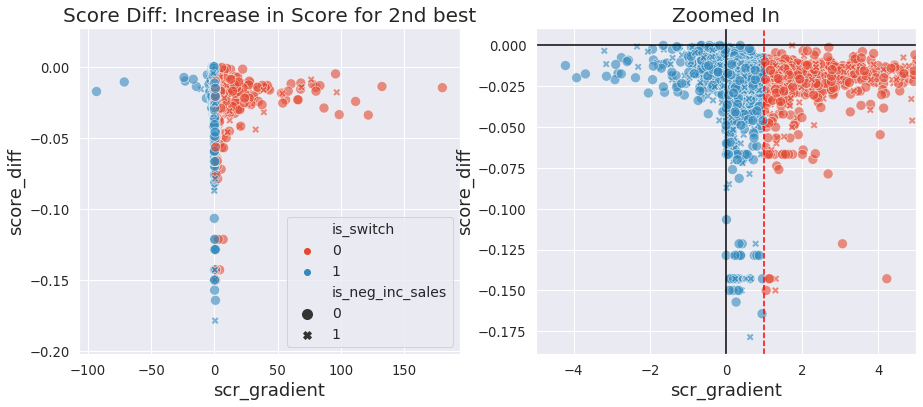

In [259]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='score_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[0])
ax[0].set_title('Score Diff: Increase in Score for 2nd best')

ax[1].axhline(y=0, c='k')
ax[1].axvline(x=0, c='k')
ax[1].axvline(x=SCR_GRADIENT_UB, c='r', ls='--')
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='score_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[1])
ax[1].set_title('Zoomed In')
ax[1].set_xlim(-5,5)
# ax[1].set_ylim(-10,50)
# ax[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1))
ax[1].get_legend().remove()
plt.show()

### Comments for above
Scores for the 2nd best offer are always less than the best offer, as expected. Since SCR gradient only considers inc-sales and target cost, and not other metrics comprising the **Score**, there are data points with high Score reductions regardless of the SCR gradient value. Considering introducing a lower bound for score_diff in conjunction with the SCR gradient upper bound.

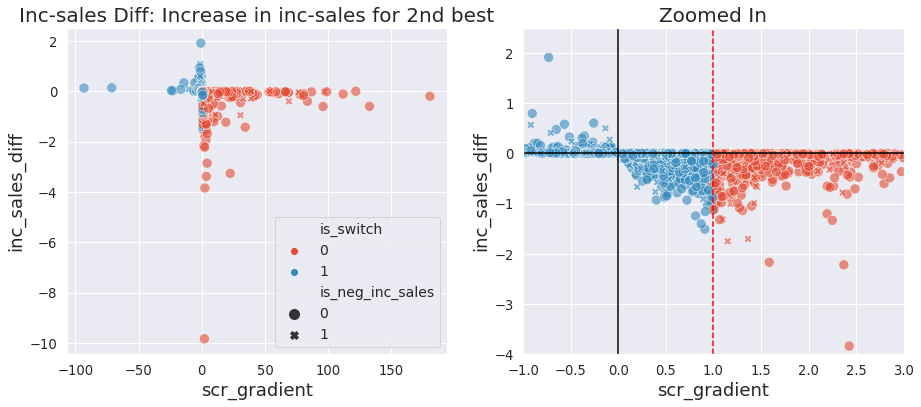

In [260]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
# ax.set(xscale="log", yscale="linear")
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='inc_sales_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[0])
ax[0].set_title('Inc-sales Diff: Increase in inc-sales for 2nd best')

ax[1].axhline(y=0, c='k')
ax[1].axvline(x=0, c='k')
ax[1].axvline(x=SCR_GRADIENT_UB, c='r', ls='--')
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='inc_sales_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[1])
ax[1].set_title('Zoomed In')
ax[1].set_xlim(-1,3)
ax[1].set_ylim(-4)
# ax[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1))
ax[1].get_legend().remove()
plt.show()

### Comments for above
Desirable inc-sales diff (increase in inc-sales for 2nd best offer) degrades with increasing SCR gradient. Setting a gradient upper bound of one restricts inc-sales reduction to a lower bound of -$2.

### Inc-sales diff percentage
Show inc-sales diff percentage filtered to offers with a minimum inc-sales of \\$0.50. The average inc-sales is \\$0.97.

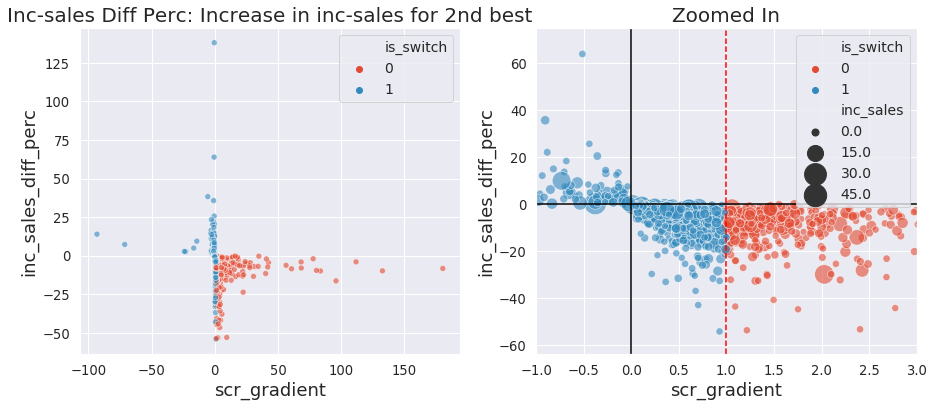

In [268]:
cond = scored_2nd['inc_sales'] >= 0.5
df_plot = scored_2nd[cond]

fig, ax = plt.subplots(1,2, figsize=(15,6))
# ax.set(xscale="log", yscale="linear")
sns.scatterplot(data=df_plot, x='scr_gradient', y='inc_sales_diff_perc',
                hue='is_switch', alpha=0.6, sizes=400,
                ax=ax[0])
ax[0].set_title('Inc-sales Diff Perc: Increase in inc-sales for 2nd best')

ax[1].axhline(y=0, c='k')
ax[1].axvline(x=0, c='k')
ax[1].axvline(x=SCR_GRADIENT_UB, c='r', ls='--')
sns.scatterplot(data=df_plot, x='scr_gradient', y='inc_sales_diff_perc',
                hue='is_switch', size='inc_sales', sizes=(50,500), alpha=0.6,
                ax=ax[1])
ax[1].set_title('Zoomed In')
ax[1].set_xlim(-1,3)
ax[1].set_ylim(top=75)
# ax[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1))
# ax[1].get_legend().remove()
plt.show()

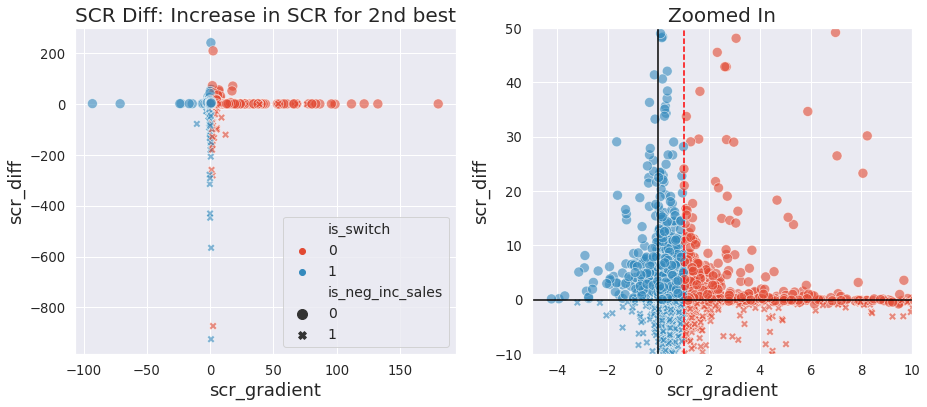

In [269]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
# ax.set(xscale="log", yscale="linear")
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='scr_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[0])
ax[0].set_title('SCR Diff: Increase in SCR for 2nd best')

ax[1].axhline(y=0, c='k')
ax[1].axvline(x=0, c='k')
ax[1].axvline(x=SCR_GRADIENT_UB, c='r', ls='--')
sns.scatterplot(data=scored_2nd, x='scr_gradient', y='scr_diff',
                hue='is_switch', style='is_neg_inc_sales', size='is_neg_inc_sales',
                sizes=[100,60], alpha=0.6,
                ax=ax[1])
ax[1].set_title('Zoomed In')
ax[1].set_xlim(-5,10)
ax[1].set_ylim(-10,50)
# ax[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1))
ax[1].get_legend().remove()
plt.show()

### Comments to above
Desirable postive SCR diff (increase in SCR for 2nd best) is higher for lower SCR gradient, with outliers shown as the top right data points. All data points with negative SCR diff have negative inc-sales and can be ignored from this analysis.

In [238]:
InteractiveShell.ast_node_interactivity = "all"

## Analysis

In [224]:
# Statistics - inc-sales average
scored_top2[cols].describe().round(2)

rank     score  inc_sales  target_cost  scr_gradient  \
count  11208.0  11208.00   11208.00     11208.00       5604.00   
mean       1.5      0.96       0.97         0.46           NaN   
std        0.5      0.04       3.43         0.81           NaN   
min        1.0      0.68     -36.18         0.00          -inf   
25%        1.0      0.95       0.00         0.02         -0.25   
50%        1.5      0.97       0.33         0.14          0.32   
75%        2.0      0.99       1.53         0.54          0.79   
max        2.0      1.00      32.88        10.12           inf   

       inc_sales_diff  target_cost_diff  
count        11208.00          11208.00  
mean            -0.04             -0.05  
std              0.28              0.24  
min            -15.40             -4.85  
25%             -0.02             -0.02  
50%              0.00              0.00  
75%              0.00              0.00  
max             10.32              3.49

In [145]:
# Gradient of 1
cond = (0.8 <= scored_2nd['scr_gradient']) & (scored_2nd['scr_gradient'] <= 1)
cond &= (0.8 <= scored_2nd['scr_diff']) & (scored_2nd['scr_diff'] <= 1)
scored_2nd[cond].shape
cond_crn = scored_2nd.loc[cond,'crn']

cols = [
#     'crn',
    'rank', 'score', 'inc_sales', 'target_cost',
    'scr', 'scr_gradient', 'inc_sales_diff', 'inc_sales_diff_perc',
    'target_cost_diff', 'target_cost_diff_perc',
    'scr_diff', 'scr_diff_perc',
]
cond_full = scored_top2['crn'].isin(cond_crn)
scored_top2.loc[cond_full, cols]

(9, 38)

rank     score  inc_sales  target_cost        scr  scr_gradient  \
25432      1  0.972131   0.426117     0.176407   2.415540           NaN   
25433      2  0.930328   0.368391     0.111926   3.291369      0.895257   
28442      1  0.983721   1.840799     0.883861   2.082680           NaN   
28443      2  0.968605   1.536782     0.531699   2.890325      0.863289   
51636      1  0.993478   3.676050     1.308298   2.809795           NaN   
51637      2  0.971739   3.314479     0.891260   3.718869      0.866996   
137362     1  0.993103   1.749251     0.730950   2.393122           NaN   
137363     2  0.978161   1.505553     0.455756   3.303423      0.885550   
164508     1  0.986232   6.327080     2.531597   2.499244           NaN   
164509     2  0.969565   5.396782     1.560345   3.458711      0.957834   
200418     1  0.998101   2.070982     0.862517   2.401091           NaN   
200419     2  0.983544   1.749886     0.534481   3.273993      0.978844   
237208     1  0.994304   1.403070     0.558888   2.510468           NaN   
237209     2  0.979747   1.213411     0.364144   3.332224      0.973892   
245996     1  0.988235   0.174514     0.014494  12.040163           NaN   
245997     2  0.970588   0.173478     0.013334  13.010170      0.892820   
263394     1  0.984058   0.075014     0.033943   2.209997           NaN   
263395     2  0.968116   0.064447     0.021279   3.028687      0.834395   

        inc_sales_diff  inc_sales_diff_perc  target_cost_diff  \
25432         0.000000             0.000000          0.000000   
25433        -0.057726           -13.547075         -0.064480   
28442         0.000000             0.000000          0.000000   
28443        -0.304018           -16.515520         -0.352162   
51636         0.000000             0.000000          0.000000   
51637        -0.361570            -9.835840         -0.417038   
137362        0.000000             0.000000          0.000000   
137363       -0.243698           -13.931566         -0.275194   
164508        0.000000             0.000000          0.000000   
164509       -0.930298           -14.703432         -0.971252   
200418        0.000000             0.000000          0.000000   
200419       -0.321096           -15.504549         -0.328036   
237208        0.000000             0.000000          0.000000   
237209       -0.189659           -13.517438         -0.194743   
245996        0.000000             0.000000          0.000000   
245997       -0.001036            -0.593607         -0.001160   
263394        0.000000             0.000000          0.000000   
263395       -0.010567           -14.086572         -0.012664   

        target_cost_diff_perc  scr_diff  scr_diff_perc  
25432                0.000000  0.000000       0.000000  
25433              -36.552090  0.875829      36.258106  
28442                0.000000  0.000000       0.000000  
28443              -39.843620  0.807645      38.779102  
51636                0.000000  0.000000       0.000000  
51637              -31.876394  0.909074      32.353764  
137362               0.000000  0.000000       0.000000  
137363             -37.648846  0.910301      38.038242  
164508               0.000000  0.000000       0.000000  
164509             -38.365192  0.959467      38.390270  
200418               0.000000  0.000000       0.000000  
200419             -38.032448  0.872901      36.354351  
237208               0.000000  0.000000       0.000000  
237209             -34.844810  0.821756      32.733189  
245996               0.000000  0.000000       0.000000  
245997              -8.005109  0.970007       8.056427  
263394               0.000000  0.000000       0.000000  
263395             -37.310009  0.818691      37.044872

In [151]:
# Check negative SCR diff (not ideal), negative gradient (ideal)
cond = (scored_2nd['scr_diff'] < 0) & (scored_2nd['scr_gradient'] < 0)

# positive gradient (not ideal) with positive SCR diff (ideal)
cond = (scored_2nd['scr_diff'] > 0) & (scored_2nd['scr_gradient'] > 0)


# Filter positive inc-sales [EMPTY]
# cond &= (scored_2nd['inc_sales'] > 0)

cond_crn = scored_2nd.loc[cond,'crn']
# cols = [
# #     'crn',
#     'rank', 'score', 'inc_sales', 'target_cost',
#     'scr_gradient', 'inc_sales_diff', 'inc_sales_diff_perc',
#     'target_cost_diff', 'target_cost_diff_perc',
#     'scr', 'scr_diff', 'scr_diff_perc',
# ]
cols = [
#     'crn',
    'rank', 'score', 'inc_sales', 'target_cost',
    'scr_gradient',
    'scr', 'scr_diff',
]
cond_full = scored_top2['crn'].isin(cond_crn)
scored_top2.loc[cond_full, cols].head(10)

rank     score  inc_sales  target_cost  scr_gradient       scr  scr_diff
42      1  0.999020   2.110014     1.352413           NaN  1.560185  0.000000
43      2  0.981373   2.059573     1.155072      0.255606  1.783068  0.222884
98      1  0.991860   0.661061     0.205635           NaN  3.214730  0.000000
99      2  0.969767   0.638184     0.133234      0.315980  4.789962  1.575232
438     1  0.992623   4.274357     1.106734           NaN  3.862137  0.000000
439     2  0.968852   4.088188     0.657749      0.414644  6.215425  2.353288
582     1  0.990506  11.341494     2.900695           NaN  3.909923  0.000000
583     2  0.982278  11.294062     1.949907      0.049887  5.792104  1.882181
746     1  0.957595  10.439659     3.849265           NaN  2.712118  0.000000
747     2  0.945570  10.107048     2.523963      0.250970  4.004436  1.292318

### Comments to above
Data show that all 2nd best offers with negative SCR diff are due solely to negative inc-sales.

In [112]:
scored_2nd['target_cost_diff'].describe()

count    4059.000000
mean       -0.180096
std         0.318359
min        -4.846928
25%        -0.213942
50%        -0.061598
75%        -0.012383
max        -0.000010
Name: target_cost_diff, dtype: float64

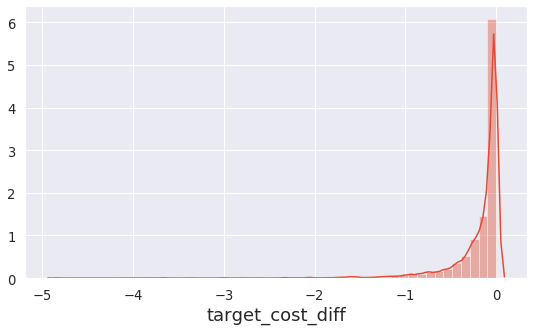

In [113]:
sns.distplot(scored_2nd['target_cost_diff'])

In [ ]:
# View sample
cond = base_crn_top2['crn'] == '1000000000000167936' #'1000000000000257266'
cond = base_crn_top2['crn'] == '1000000000000257266'
cond = base_crn_top2['crn'] == '1000000000000005953'
switch_crn.loc[cond,cols]